The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
before init: Parameter containing:
tensor([[-0.0210, -0.0086],
        [-0.0938,  0.0575],
        [-0.1430, -0.0441],
        [ 0.0969,  0.2347],
        [ 0.0589, -0.0848],
        [ 0.0240, -0.0280],
        [ 0.1020,  0.0286],
        [ 0.0979,  0.2425],
        [-0.1038, -0.0088],
        [ 0.0575, -0.0016],
        [-0.0239, -0.2212],
        [-0.2157, -0.2250],
        [-0.2446, -0.2328],
        [-0.1894, -0.2255],
        [-0.2345,  0.1096],
        [ 0.1533,  0.1689]], requires_grad=True)
after init: Parameter containing:
tensor([[-0.0745, -1.9735],
        [ 1.2275, -3.1214],
        [ 1.4188, -0.7852],
        [-3.7154, -0.4104],
        [-1.2799, -0.2104],
        [-1.4858, -1.9971],
        [ 1.4116, -2.1446],
        [ 0.7898, -1.6669],
        [ 0.2296, -1.0742],
        [-0.2447, -1.9985],
        [ 1.7249,  0.4197],
        [-0.1662,  0.7507],
        [-6.5849,  1.4012],
        

Launching TensorBoard...

D:\AGH\Projects\ANN\CNN_autoencoder\project\env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


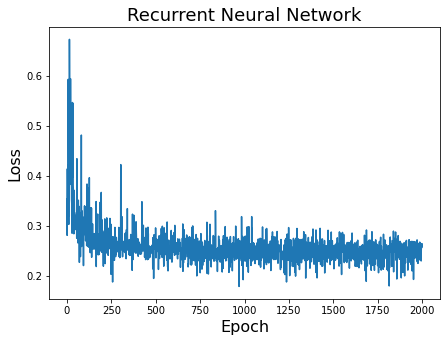

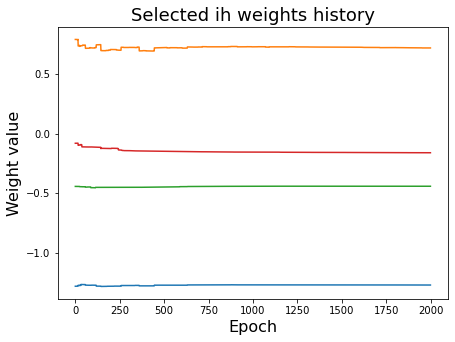

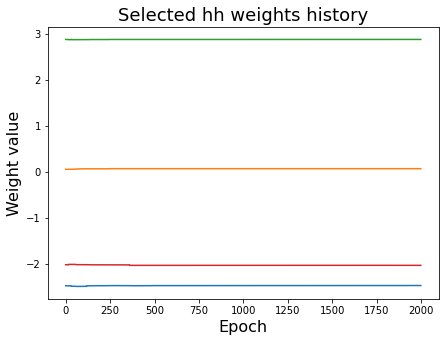

In [3]:

# https://github.com/mineshmathew/pyTorch_RNN_Examples/blob/master/BinaryStringAddition/AddBinaryStrings.py.ipynb
# ============================================================================
# Make a simple RNN learn binary addition
# ============================================================================
# author  mineshmathew.github.io
# ============================================================================

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import random
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
#wyświetlić wybrane 4 czy też 16 wag,jak wygląda nauka w procesie trenowania
#dlaczego inicjalizuje randomowo a nie zerami?
#wyświetlić gradienty (podłączyć tensorboard i wyświetlać lossa, histogram
#gradientow (dystrybucja delt, ale wag tez mozna)

torch.random.manual_seed(10)
# %load_ext tensorboard
# %reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}
#%tensorboard --logdir logs
writer = SummaryWriter()

def getSample(stringLength, testFlag):
  #takes stringlength as input
  #returns a sample for the network - an input sequence - x and its target -y
  #x is a T*2 array, T is the length of the string and 2 since we take one bit each from each string
  #testFlag if set prints the input numbers and its sum in both decimal and binary form
  lowerBound=pow(2,stringLength-1)+1
  upperBound=pow(2,stringLength)

  num1=random.randint(lowerBound,upperBound)
  num2=random.randint(lowerBound,upperBound)
  # num1 = 67
  # num2 = 69

  num3=num1+num2
  num3Binary=(bin(num3)[2:])
  num1Binary=(bin(num1)[2:])
  num2Binary=(bin(num2)[2:])

  if testFlag==1:
    print('input numbers and their sum are: ', num1, ', ', num2, ', ', num3)
    print ('binary strings are: ', num1Binary, ', ' , num2Binary, ', ' , num3Binary)
  len_num1= (len(num1Binary))
  len_num2= (len(num2Binary))
  len_num3= (len(num3Binary))

  # since num3 will be the largest, we pad other numbers with zeros to that num3_len
  num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
  num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)

  # num1Binary = np.array(list(reversed(num1Binary)))
  # num2Binary = np.array(list(reversed(num2Binary)))
  # num3Binary = np.array(list(reversed(num3Binary)))

  # forming the input sequence
  # the input at first timestep is the least significant bits of the two input binary strings
  # x will be then a len_num3 ( or T ) * 2 array
  x=np.zeros((len_num3,2),dtype=np.int)
  for i in range(0, len_num3):
    x[i,0]=num1Binary[len_num3-1-i] # note that MSB of the binary string should be the last input along the time axis
    x[i,1]=num2Binary[len_num3-1-i]
  # target vector is the sum in binary
  # convert binary string in <string> to a numpy 1D array
  #https://stackoverflow.com/questions/29091869/convert-bitstring-string-of-1-and-0s-to-numpy-array
  # print('num3Binary')
  #y=np.array(map(int, num3Binary[::-1]))
  y = np.fromiter(num3Binary[::-1], dtype=np.int)
  if testFlag==1:
    print('a,b,c current  are: {},{},{}'.format(np.array(x[:,0]),
                                              np.array(x[:,1]),
                                              np.array(y)))
  return x,y

class Adder (nn.Module):
  def __init__(self, inputDim, hiddenDim, outputDim):
    super(Adder, self).__init__()
    self.inputDim=inputDim
    self.hiddenDim=hiddenDim
    self.outputDim=outputDim
    self.rnn=nn.RNN(inputDim, hiddenDim)
    self.outputLayer=nn.Linear(hiddenDim, outputDim)
    self.sigmoid=nn.Tanh()#nn.Sigmoid()
  def forward(self, x):
    #size of x is T x B x featDim
    #B=1 is dummy batch dimension added, because pytorch mandates it
    #if you want B as first dimension of x then specift batchFirst=True when LSTM is initalized
    #T,D  = x.size(0), x.size(1)
    #batch is a must
    rnnOut, hidd = self.rnn(x) #x has two  dimensions  seqLen *batch* FeatDim=2
    #torch.nn.init.normal()
    #print('hidd: {}'.format(hidd))
    T,B,D  = rnnOut.size(0),rnnOut.size(1),rnnOut.size(2)
    #print('RNN output size is: {}'.format(rnnOut.size()))
    rnnOut = rnnOut.contiguous()
        # before  feeding to linear layer we squash one dimension
    rnnOut = rnnOut.view(B*T, D)
    outputLayerActivations=self.outputLayer(rnnOut)
    #reshape activations to T*B*outputlayersize
    outputLayerActivations=outputLayerActivations.view(T,B,-1).squeeze(1)
    #print('After squeezing it is: {}'.format(outputLayerActivations.size()))
    outputSigmoid=self.sigmoid(outputLayerActivations)
    return outputSigmoid, hidd

  def init_hidden(self):
    #W = torch.zeros(1, 1, dim_b)
    W = 2*torch.rand((1, 1, self.hiddenDim))-1
    return W

featDim=2 #two bits each from each of the String
outputDim=1 #one output node which would output a zero or 1
lstmSize=16

lossFunction = nn.MSELoss()
model = Adder(featDim, lstmSize, outputDim)
# print('Param: {}'.format(model.parameters()))
# print('hiddenDim: {}'.format(model.hiddenDim))
# l = [module for module in model.modules()]
# print(l)
print('before init: {}'.format(model.rnn.weight_ih_l0))
#print(model.rnn.all_weights[0][0]))
model.rnn.weight_hh_l0 = nn.Parameter(2*torch.randn_like(model.rnn.weight_hh_l0)-1)
model.rnn.weight_ih_l0 = nn.Parameter(2*torch.randn_like(model.rnn.weight_ih_l0)-1)
#model.rnn.bias_hh_l0 = nn.Parameter(torch.randn_like(model.rnn.bias_hh_l0))
#model.rnn.bias_ih_l0 = nn.Parameter(torch.randn_like(model.rnn.bias_ih_l0))
print('after init: {}'.format(model.rnn.weight_ih_l0))

print ('Model initialized')
optimizer = optim.SGD(model.parameters(), lr=0.01)
#optimizer=optim.Adam(model.parameters(), lr=0.1)
epochs=2000
### epochs ##
totalLoss=0
loss_hist = []
selected_ih = []
selected_hh = []
selected_ih_hist = []
selected_hh_hist = []
for i in range(0,epochs):
    stringLen=8
    testFlag=0

    x,y=getSample(stringLen, testFlag)
    optimizer.zero_grad()
    #x_var=autograd.Variable(torch.from_numpy(x).unsqueeze(1).float()) #convert to torch tensor and variable
    x_var=torch.from_numpy(x).unsqueeze(1).float()
    # unsqueeze() is used to add the extra dimension since
    # your input need to be of t*batchsize*featDim; you cant do away with the batch in pytorch
    seqLen=x_var.size(0)
    x_var= x_var.contiguous()
    #y_var=autograd.Variable(torch.from_numpy(y).float())
    y_var=torch.from_numpy(y).float()
    finalScores, hidd = model(x_var)
    #print('ih_lo[4][0]: {}'.format(model.rnn.weight_ih_l0[4][0]))
    selected_ih = [model.rnn.weight_ih_l0[4][0].item(),
                   model.rnn.weight_ih_l0[7][0].item(),
                   model.rnn.weight_ih_l0[13][1].item(),
                   model.rnn.weight_ih_l0[15][1].item()]
    selected_hh = [model.rnn.weight_hh_l0[4][3].item(),
                   model.rnn.weight_hh_l0[13][2].item(),
                   model.rnn.weight_hh_l0[3][15].item(),
                   model.rnn.weight_hh_l0[14][12].item()]
    #print('hidd is: {}'.format(hidd))
    #print('input: {}, output: {}'.format(x_var, finalScores))
    #finalScores=finalScores.


    loss=lossFunction(finalScores,y_var)
    totalLoss+=loss.data
    #optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist.append(loss)
    selected_ih_hist.append(selected_ih)
    selected_hh_hist.append(selected_hh)

    writer.add_scalar("Loss/train", loss, i)

writer.flush()
writer.close()

totalLoss=totalLoss/epochs
print('Final total loss is:' + str(totalLoss))
print('after training: {}'.format(model.rnn.weight_ih_l0))

###### Plot loss history ######

fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,epochs,1)
plt.plot(epoch, loss_hist, linestyle="solid")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Recurrent Neural Network", fontsize=18)
plt.show()


fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,epochs,1)
plt.plot(epoch, selected_ih_hist, linestyle="solid")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Weight value", fontsize=16)
plt.title("Selected ih weights history", fontsize=18)
plt.show()

fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,epochs,1)
plt.plot(epoch, selected_hh_hist, linestyle="solid")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Weight value", fontsize=16)
plt.title("Selected hh weights history", fontsize=18)
plt.show()


In [2]:
###### Testing the model ######

stringLen=5
testFlag=1
# test the network on 10 random binary string addition cases where stringLen=4
for i in range (0,10):
	x,y=getSample(stringLen,testFlag)
	print('x and y are: {}, {}'.format(x,y))
	#x_var=autograd.Variable(torch.from_numpy(x).unsqueeze(1).float())
	#y_var=autograd.Variable(torch.from_numpy(y).float())
	x_var=torch.from_numpy(x).unsqueeze(1).float()
	y_var=torch.from_numpy(y).float()
	seqLen=x_var.size(0)
	x_var= x_var.contiguous()
	finalScores = model(x_var).data.t()
	print('model output: {}'.format(finalScores))
	bits=np.round(finalScores)
	print('result is {}'.format(bits))

	#print('sum predicted by RNN is ',bits[::-1])
	print('--------------------------------------------')

input numbers and their sum are:  30 ,  25 ,  55
binary strings are:  11110 ,  11001 ,  110111
a,b,c current  are: [0 1 1 1 1 0],[1 0 0 1 1 0],[1 1 1 0 1 1]
x and y are: [[0 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [0 0]], [1 1 1 0 1 1]


AttributeError: 'tuple' object has no attribute 'data'